                                     CVXPY                                     
                                     v1.3.4                                    
(CVXPY) May 07 05:23:44 PM: Your problem has 256 variables, 1 constraints, and 0 parameters.
(CVXPY) May 07 05:23:44 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) May 07 05:23:44 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) May 07 05:23:44 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) May 07 05:23:44 PM: Compiling problem (target solver=ECOS).
(CVXPY) May 07 05:23:44 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -

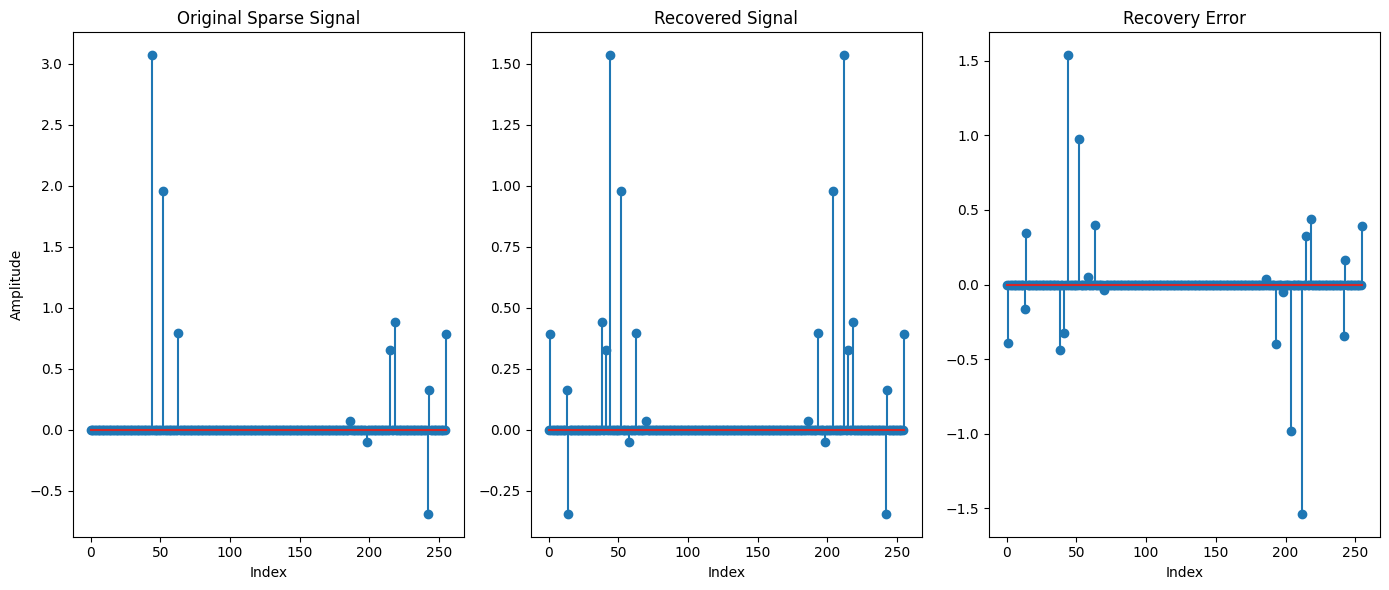

In [7]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

# --- Parameters ---
n = 256              # Signal length
S = 10               # Sparsity level
C = 2                # Constant in k > C·S·log(n)
k = int(C * S * np.log(n))  # Number of measurements

# --- Generate sparse signal x_true ---
x_true = np.zeros(n)
nonzero_indices = np.random.choice(n, S, replace=False)
x_true[nonzero_indices] = np.random.randn(S)

# --- Create DFT matrix and measurement matrix Φ ---
def dft_matrix(n):
    i, j = np.meshgrid(np.arange(n), np.arange(n))
    omega = np.exp(-2j * np.pi / n)
    W = np.power(omega, i * j) / np.sqrt(n)
    return W

F = dft_matrix(n)
row_indices = np.random.choice(n, k, replace=False)
Phi = F[row_indices, :].real   # real part only

# --- Measurement vector ---
y = Phi @ x_true

# --- ℓ₁ minimization ---
x = cp.Variable(n)
objective = cp.Minimize(cp.norm1(x))
constraints = [Phi @ x == y]
problem = cp.Problem(objective, constraints)
problem.solve(verbose=True)

x_rec = x.value
rel_error = np.linalg.norm(x_true - x_rec) / np.linalg.norm(x_true)
print(f"Relative recovery error: {rel_error:.4e}")

# --- Plot original and recovered signals ---
plt.figure(figsize=(14, 6))

plt.subplot(1, 3, 1)
plt.stem(x_true, use_line_collection=True)
plt.title("Original Sparse Signal")
plt.xlabel("Index")
plt.ylabel("Amplitude")

plt.subplot(1, 3, 2)
plt.stem(x_rec, use_line_collection=True)
plt.title("Recovered Signal")
plt.xlabel("Index")

plt.subplot(1, 3, 3)
plt.stem(x_true - x_rec, use_line_collection=True)
plt.title("Recovery Error")
plt.xlabel("Index")

plt.tight_layout()
plt.show()


## Section B

In [ ]:
import numpy as np
import cvxpy as cp

def build_sparse_vector(length, nonzeros):
    vector = np.zeros(length)
    indices = np.random.choice(length, nonzeros, replace=False)
    vector[indices] = np.random.randint(1, 10, size=nonzeros)
    return vector

def create_measurement_matrix(n, selected_indices):
    row_indices = selected_indices.reshape(-1, 1)
    col_indices = np.arange(n)
    omega = np.exp(-1j * 2 * np.pi * row_indices * col_indices / n)
    return omega / np.sqrt(n)

def attempt_recovery(y, sensing_matrix, signal_length):
    x = cp.Variable(signal_length)
    problem = cp.Problem(cp.Minimize(cp.norm1(x)), [sensing_matrix @ x == y])
    try:
        problem.solve(solver=cp.SCS)
        return x.value
    except:
        return None

def find_smallest_k(n, s, tol=1e-5, verbose=False):
    original = build_sparse_vector(n, s)
    for k in range(s, n + 1):
        freq_indices = np.sort(np.random.choice(n, k, replace=False))
        Phi = create_measurement_matrix(n, freq_indices)
        y = Phi @ original
        recovered = attempt_recovery(y, Phi, n)
        if recovered is not None and np.linalg.norm(recovered - original) < tol:
            if verbose:
                print(f"[✓] Success: n={n}, S={s}, k={k}")
            return k
    return None


# Example: Test multiple n and S
n_values = [50, 75, 100]
s_values = [5, 7, 10]

results = {}
for n in n_values:
    for s in s_values:
        if s < n:
            k_result = find_smallest_k(n, s, verbose=True)
            results[(n, s)] = k_result



[✓] Success: n=50, S=5, k=11
[✓] Success: n=50, S=7, k=16
[✓] Success: n=50, S=10, k=23
[✓] Success: n=75, S=5, k=21
[✓] Success: n=75, S=7, k=25
[✓] Success: n=75, S=10, k=38
[✓] Success: n=100, S=5, k=20
[✓] Success: n=100, S=7, k=68
[✓] Success: n=100, S=10, k=36


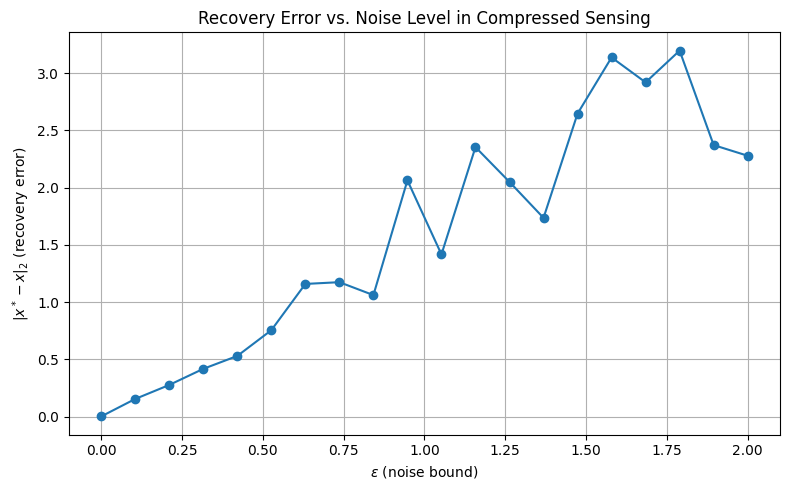

In [22]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

# Step 1: Set up original signal and sensing matrix
n = 100              # Signal length
S = 5               # Sparsity level
k = 25              # Number of measurements (choose one that works well from part b)
np.random.seed(42)  # For reproducibility

# Generate sparse signal x
x_true = np.zeros(n)
support = np.random.choice(n, S, replace=False)
x_true[support] = np.random.randint(1, 10, size=S)

# Randomly select k frequency indices for DFT rows
freq_indices = np.sort(np.random.choice(n, k, replace=False))
f = freq_indices.reshape(-1, 1)
m = np.arange(n)
Phi = (1 / np.sqrt(n)) * np.exp(-1j * 2 * np.pi * f * m / n)

# Generate clean measurements
y_clean = Phi @ x_true

# Step 2: Try different noise levels (epsilon values)
epsilons = np.linspace(0, 2, 20)
errors = []

for eps in epsilons:
    # Add bounded Gaussian noise
    noise = np.random.randn(k) + 1j * np.random.randn(k)
    noise = noise / np.linalg.norm(noise) * eps
    y_noisy = y_clean + noise

    # Solve basis pursuit denoising: minimize ||x||_1 s.t. ||y - Phi x||_2 <= eps
    x_var = cp.Variable(n)
    objective = cp.Minimize(cp.norm1(x_var))
    constraints = [cp.norm(Phi @ x_var - y_noisy, 2) <= eps]
    problem = cp.Problem(objective, constraints)
    problem.solve(solver=cp.SCS)

    x_hat = x_var.value
    err = np.linalg.norm(x_hat - x_true)
    errors.append(err)

# Plot the result
plt.figure(figsize=(8, 5))
plt.plot(epsilons, errors, marker='o')
plt.xlabel(r"$\varepsilon$ (noise bound)")
plt.ylabel(r"$\|x^* - x\|_2$ (recovery error)")
plt.title("Recovery Error vs. Noise Level in Compressed Sensing")
plt.grid(True)
plt.tight_layout()
plt.show()